# Chapter 7: learning the best cut

In [1]:
import os
import cPickle as pkl
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

plt.style.use('seaborn-paper')
plt.rc('text', usetex=False)

import warnings
warnings.filterwarnings('ignore')

# 0. Load training/validation data

In [2]:
# Training
data_tr = pd.read_csv('../../scripts/aism/dataset_12-2017/data_training.csv', header=0, index_col=0)
labels_tr = pd.read_csv('../../scripts/aism/dataset_12-2017/labels_training.csv', header=0, index_col=0)
yy = np.where(labels_tr.values == 'SP', 1, 0)  # map RR - SP / 0 - 1
labels_tr = pd.DataFrame(data=yy, index=labels_tr.index, columns=labels_tr.columns)

In [3]:
# Validation
data_vld = pd.read_csv('../../scripts/aism/dataset_12-2017/data_valid.csv', header=0, index_col=0)
labels_vld = pd.read_csv('../../scripts/aism/dataset_12-2017/labels_valid.csv', header=0, index_col=0)
yy = np.where(labels_vld.values == 'SP', 1, 0)  # map RR - SP / 0 - 1
labels_vld = pd.DataFrame(data=yy, index=labels_vld.index, columns=labels_vld.columns)

## 0.1 Load SS results

In [4]:
def load_pkl(filename):
    """Load the input pkl file."""
    with open(filename,'rb') as f:
        dd = pkl.load(f)
    return dd

# Model names
names = ['gradient_boosting', 'random_forests', 'l1l2',
        'l2_logistic_regression', 'l1_logistic_regression',
        'linear_svc_l2', 'linear_svc_l1']

tails = ['_scores', '_coefs']

scores = {}
coefs = {}

# Load the pickles
for name in names:
    scores[name] = load_pkl(os.path.join('..', '..', 'scripts', 'aism', name+tails[0]+'.pkl'))
    coefs[name] = load_pkl(os.path.join('..', '..', 'scripts', 'aism', name+tails[1]+'.pkl'))

# 1. Define models

In [49]:
from l1l2py.classification import L1L2Classifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.svm import LinearSVC

def create_pipelines():
    """Create all the models organized in a dictionary."""
    names = [
        'gradient_boosting',
        'random_forests',
        'l1l2',
        'l2_logistic_regression',
        'l1_logistic_regression',
        'linear_svc_l2',
        'linear_svc_l1',
        ]

    estimators = [
        GradientBoostingClassifier(learning_rate=0.05),
        RandomForestClassifier(),
        L1L2Classifier(),
        LogisticRegression(penalty='l2'),
        LogisticRegression(penalty='l1'),
        LinearSVC(penalty='l2'),
        LinearSVC(penalty='l1', dual=False)
        ]

    params = [
        {'predict__max_depth': map(int, np.linspace(10, 100, 15)), # gradient_boosting
         'predict__n_estimators': map(int, np.linspace(10, 500, 15)),
         'predict__max_features': ['log2', 'sqrt', 0.5, None]},
        {'predict__max_features': np.linspace(0.1, 0.9, 10),  # random_forests
         'predict__min_samples_leaf': np.arange(1, 10),
         'predict__n_estimators': [1000]},
        {'predict__alpha': np.logspace(-3, 2, 30),  # l1l2
         'predict__l1_ratio': np.linspace(1e-3, 1, 30)},
        {'predict__C': np.logspace(-3, 2, 30)},  # l2 logistic regression
        {'predict__C': np.logspace(-3, 2, 30)},  # l1 logistic regression
        {'predict__C': np.logspace(-3, 3, 15)},  # linear svc l2
        {'predict__C': np.logspace(-3, 3, 15)}  # linear svc l1
        ]

    # Create all the cross-validated pipeline objects
    pipes = {}
    for name, estimator, param in zip(names, estimators, params):
        pipe = Pipeline([['preproc', MinMaxScaler()],
                         ['predict', estimator]])
        pipes[name] = GridSearchCV(estimator=pipe,
                                   param_grid=param,
                                   n_jobs=-1)
    return pipes

In [50]:
models = create_pipelines()

# 2. Fit on increasingly wider training sets

In [7]:
def flatten(x):
    """Flatten a list."""
    return [y for l in x for y in flatten(l)] if type(x) in (list, np.ndarray) else [x]

In [8]:
from sklearn import metrics

def evaluate(estimator, X, y):
    """Compute the selected metrics on the input (test) set."""
    y_pred = estimator.predict(X)
    # metrics
    acc = metrics.accuracy_score(y, y_pred)
    prec = metrics.precision_score(y, y_pred)
    rcll = metrics.recall_score(y, y_pred)
    mcc = metrics.matthews_corrcoef(y, y_pred)
    return {'accuracy': acc, 'precision': prec,
            'recall': rcll, 'MCC': mcc}

In [9]:
from collections import Counter

model_scores_trend = {} # keep track of the scores trend
rankings = {}
for name in models.keys():
    print('Evaluating {} ...'.format(name))
    mdl = models[name]

    # Get the variable ranking
    c = dict(Counter(flatten([c.tolist() for c in coefs[name]])))
    c = pd.DataFrame(data=c.values(), index=c.keys(), columns=['selections'])
    ranking = c.sort_values('selections', ascending=False)
    rankings[name] = ranking

#     # First divide the variables in blocks according
#     # to their selection frequency (exclude features selected 0 times)
#     sel_thresholds = filter(lambda x: x>0, np.unique(ranking.values))
    
#     # Iterate on the thresholds and create the reduced subset of features
#     metrics_thresh = {}
#     for thresh in sel_thresholds:
#         idx = np.where(ranking.values >= thresh)[0]  # get the indexes of the variables selected more than thresh times
#         var = ranking.iloc[idx].index.tolist()  # get the actual variables list
#         X, y = data_tr[var].values, labels_tr  # make the smaller X and the the y
        
#         # Fit model
#         mdl.fit(X, y)

#         # Save each metric for the current threshold
#         _metrics = evaluate(mdl, data_vld[var].values, labels_vld)
#         #print('[Thresh {:2.0f}] MCC on vld: {:2.3f}'.format(thresh, _metrics['MCC']))
#         metrics_thresh[thresh] = _metrics
#     print('done.')
    
#     # Save the model scores
#     model_scores_trend[name] = metrics_thresh

Evaluating linear_svc_l2 ...
Evaluating linear_svc_l1 ...
Evaluating random_forests ...
Evaluating l1l2 ...
Evaluating l1_logistic_regression ...
Evaluating l2_logistic_regression ...
Evaluating gradient_boosting ...


In [37]:
# Save scores trend to disk
#with open('model_scores_trend.pkl', 'wb') as f:
#    pkl.dump(model_scores_trend, f)

In [10]:
# Load scores trend
with open('model_scores_trend.pkl', 'rb') as f:
    model_scores_trend = pkl.load(f)

# 3. Get the list of selected variables optimized on the validation set

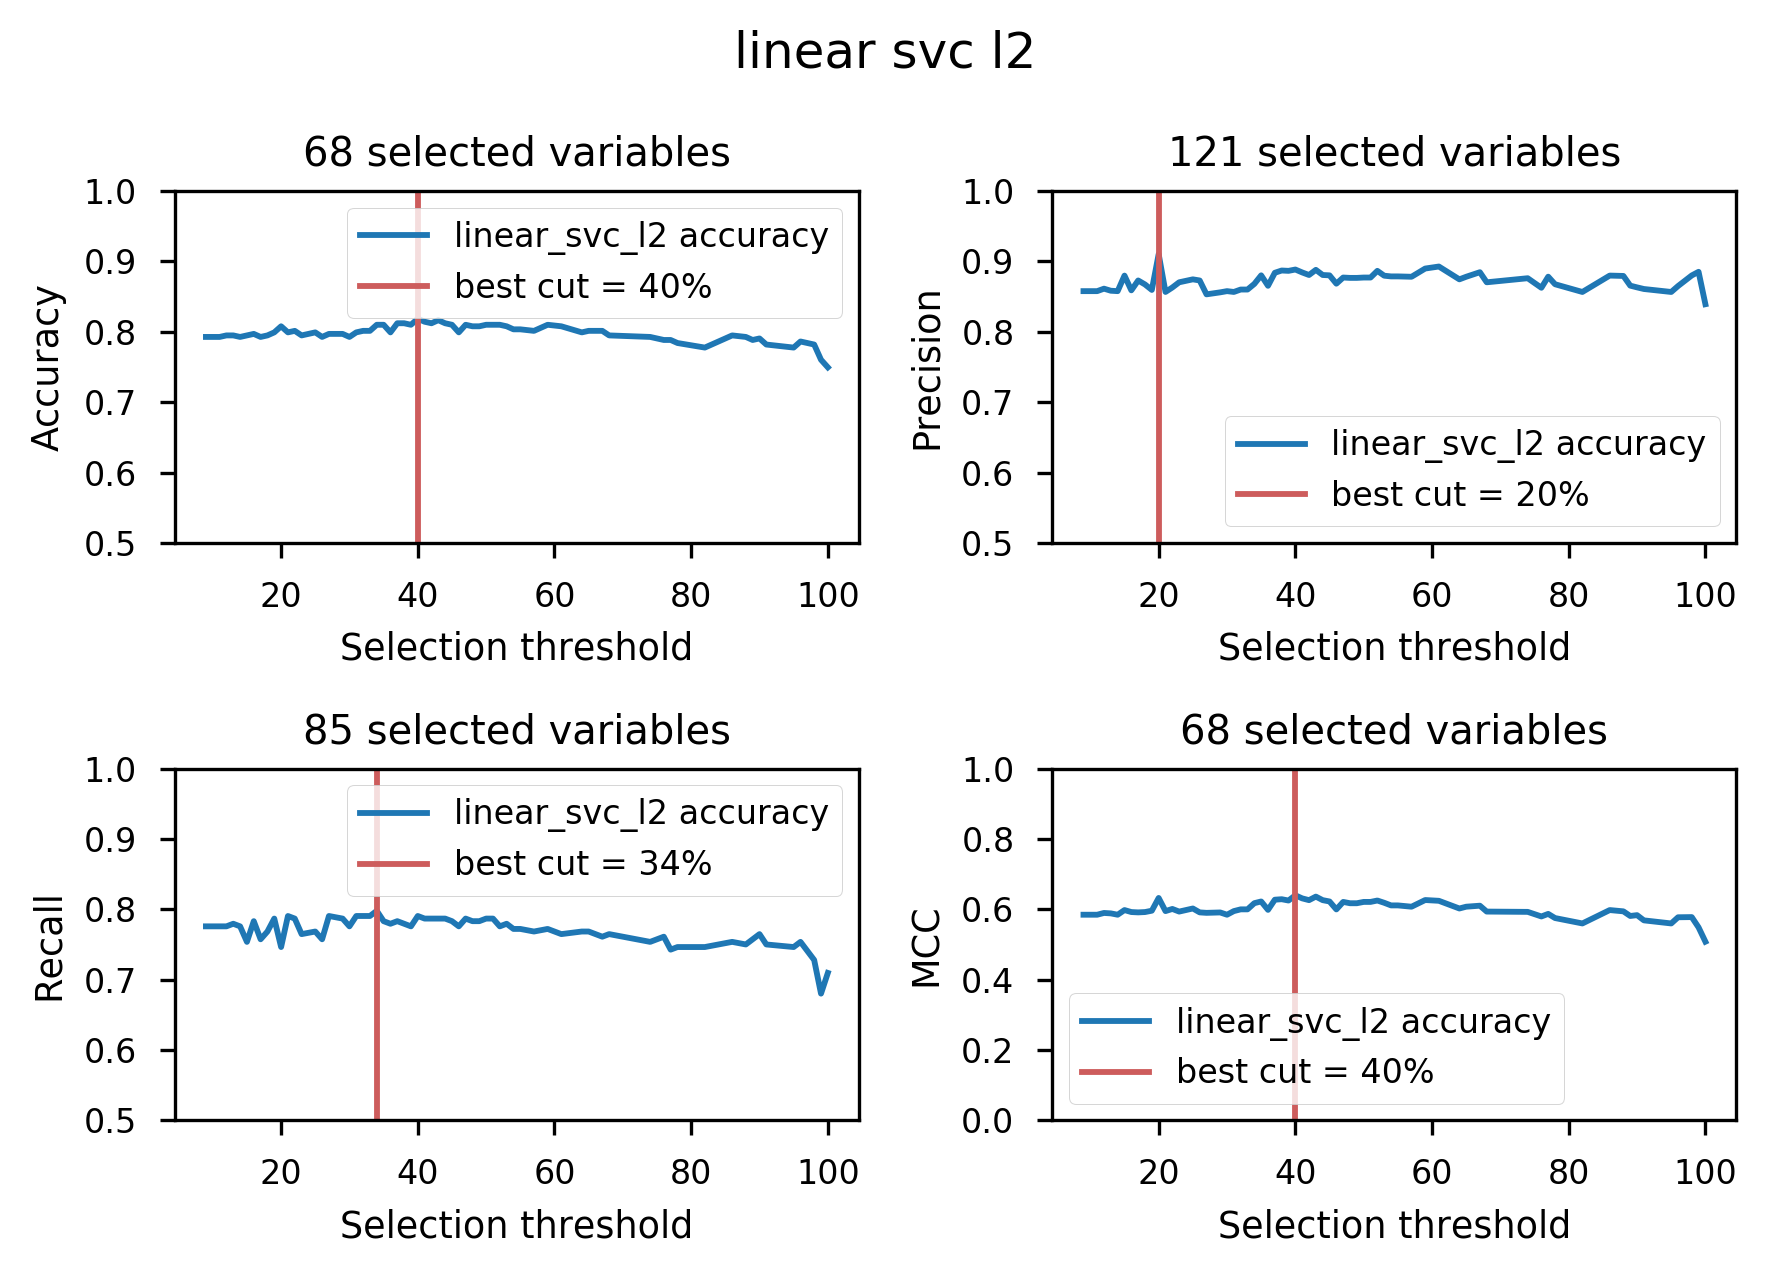

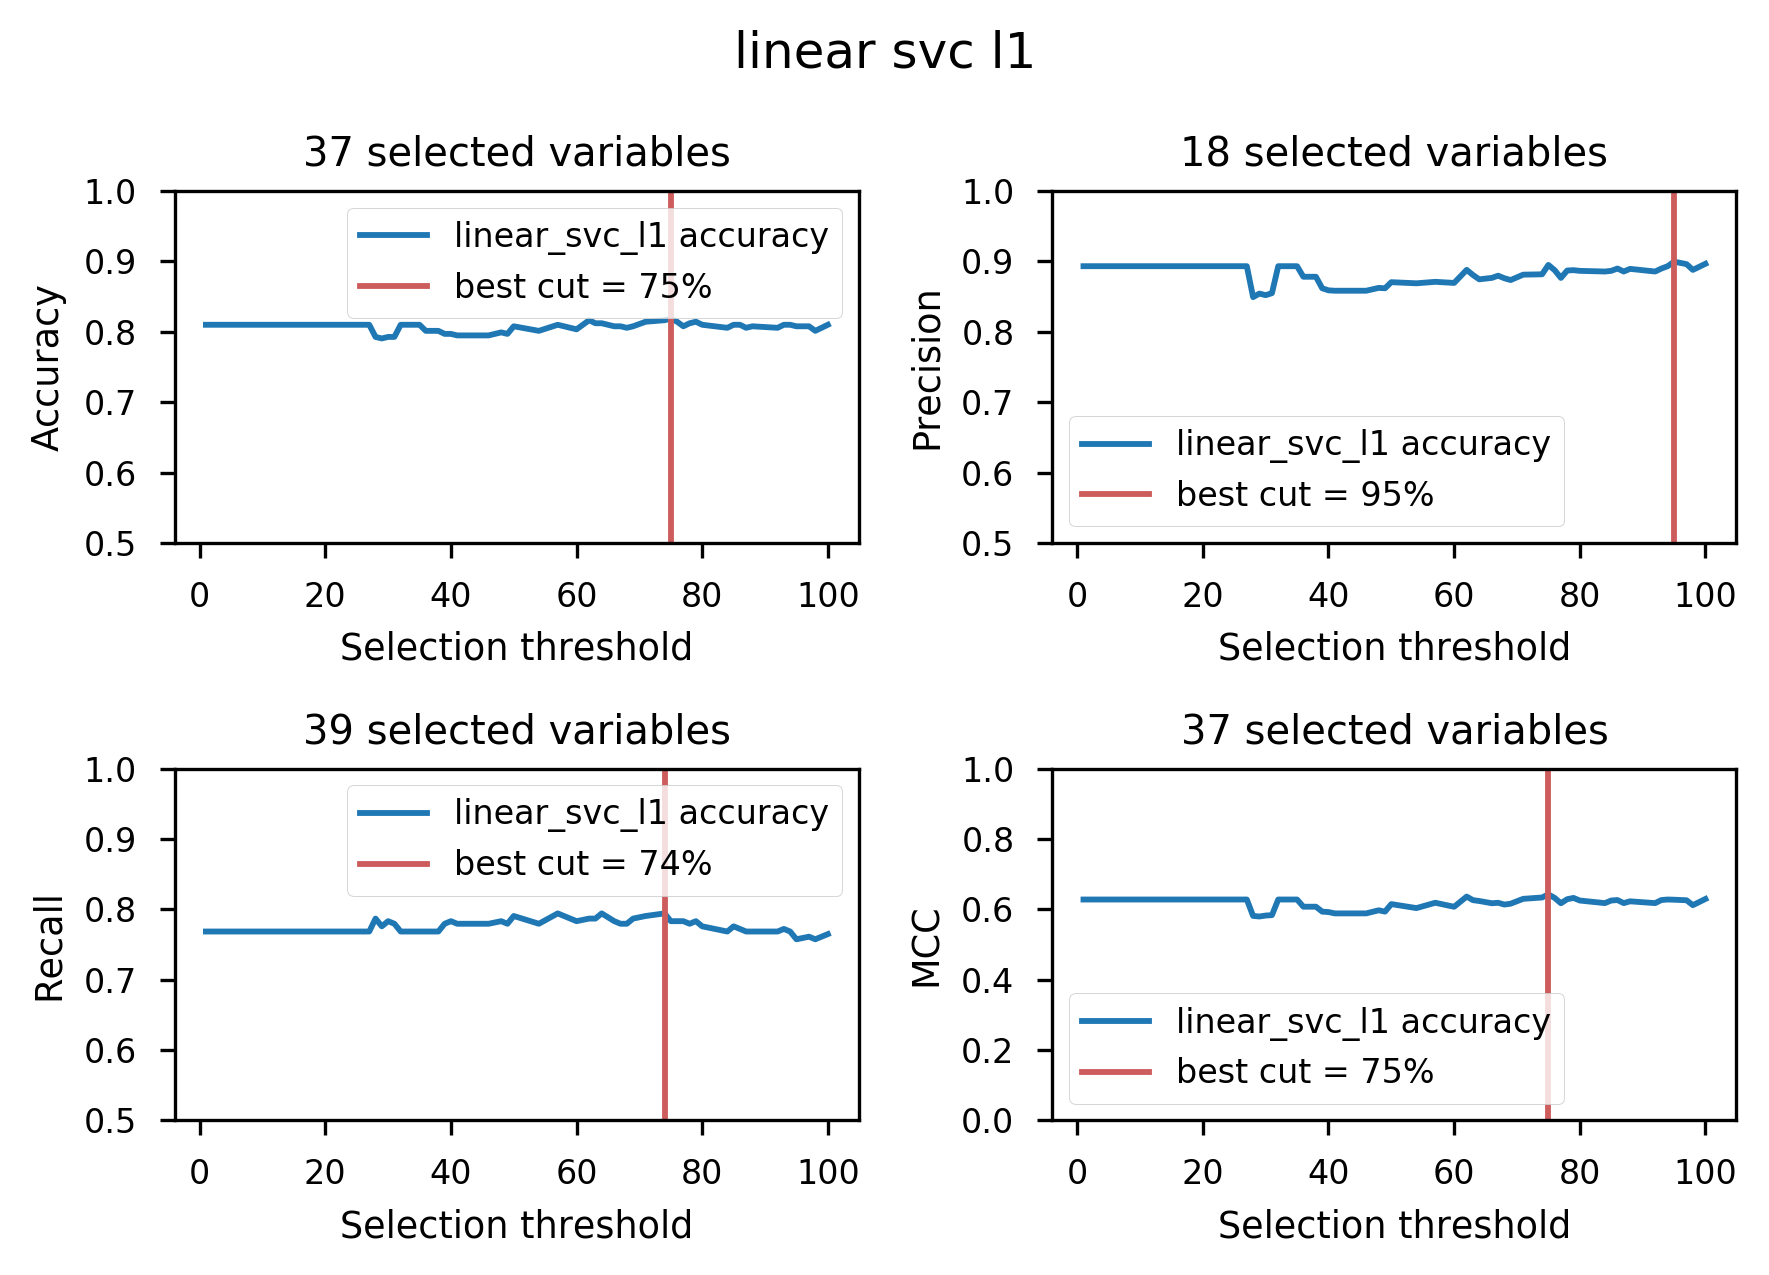

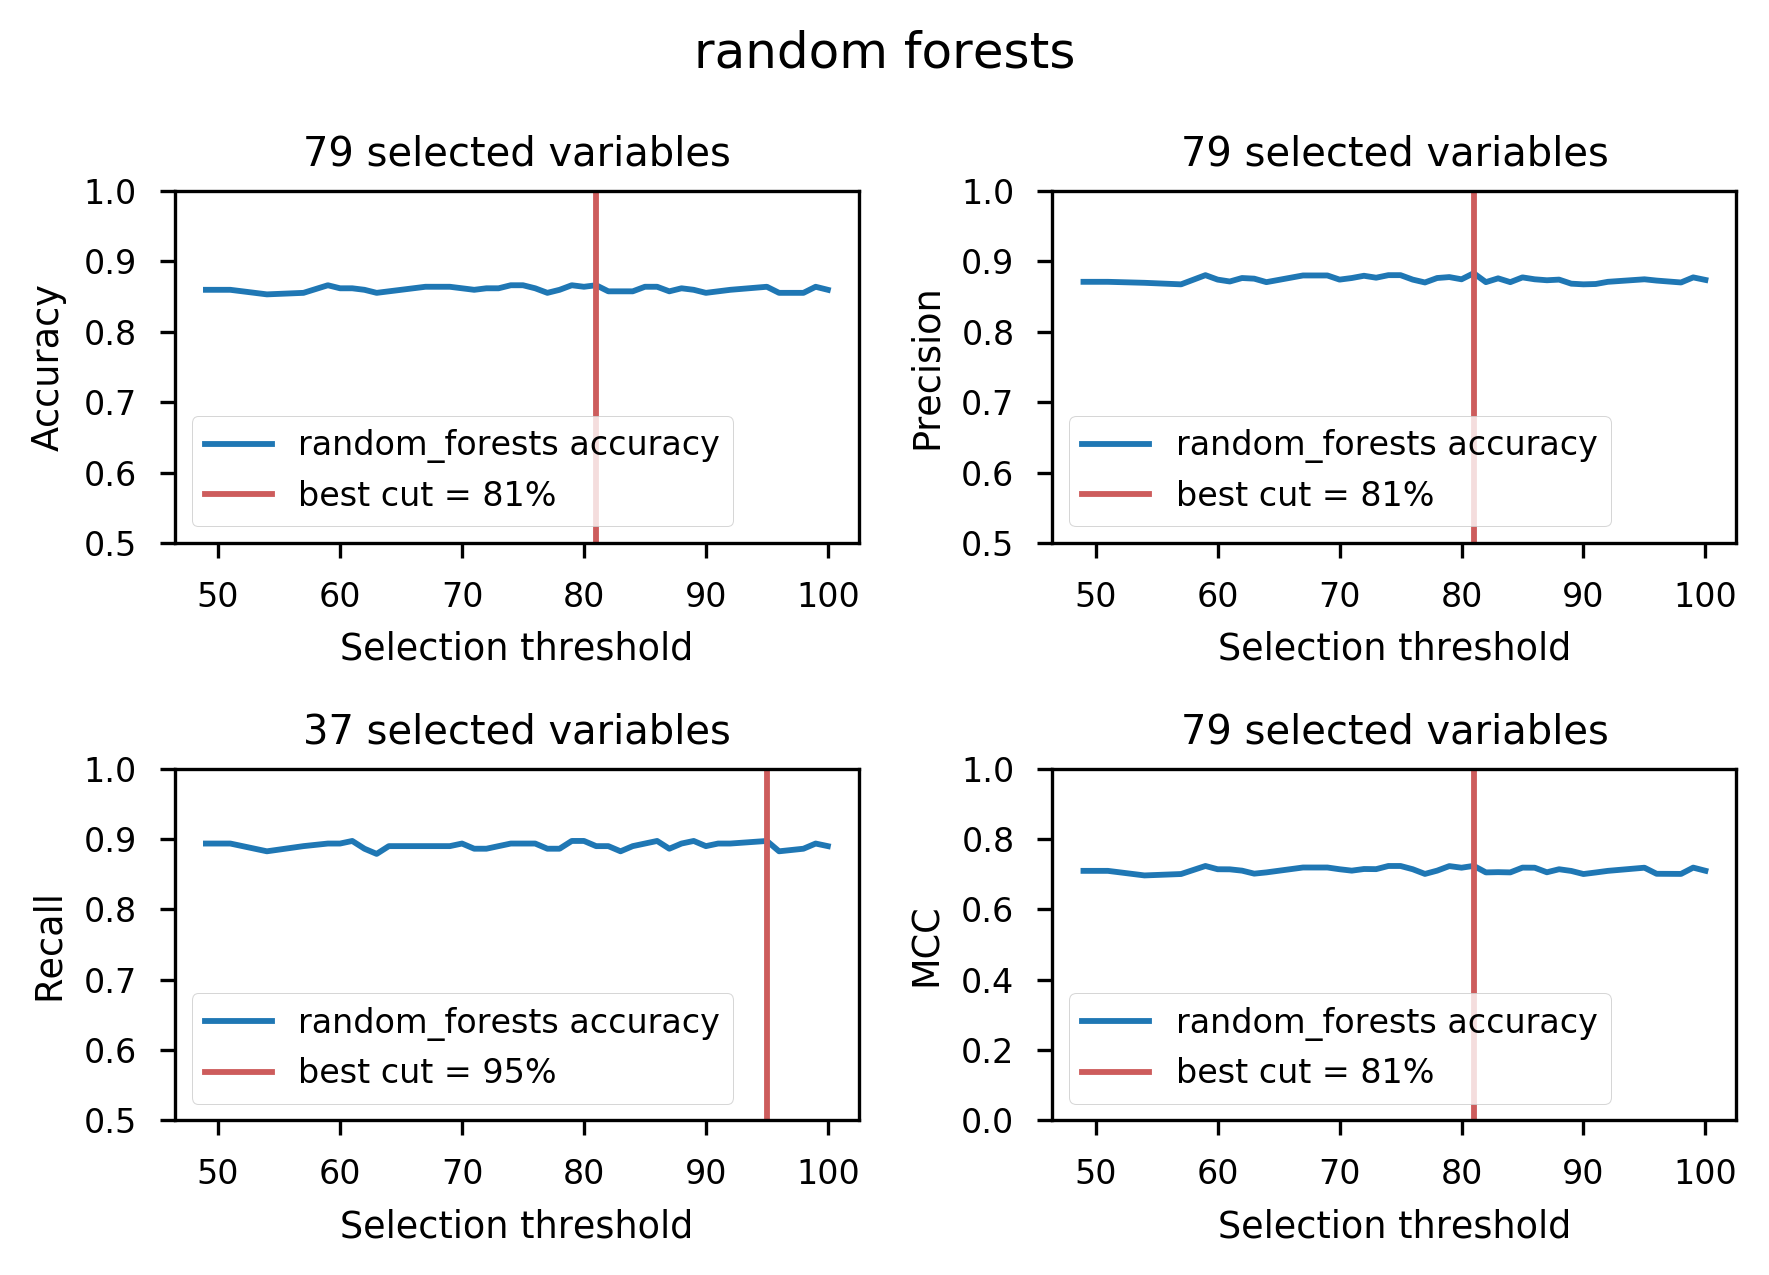

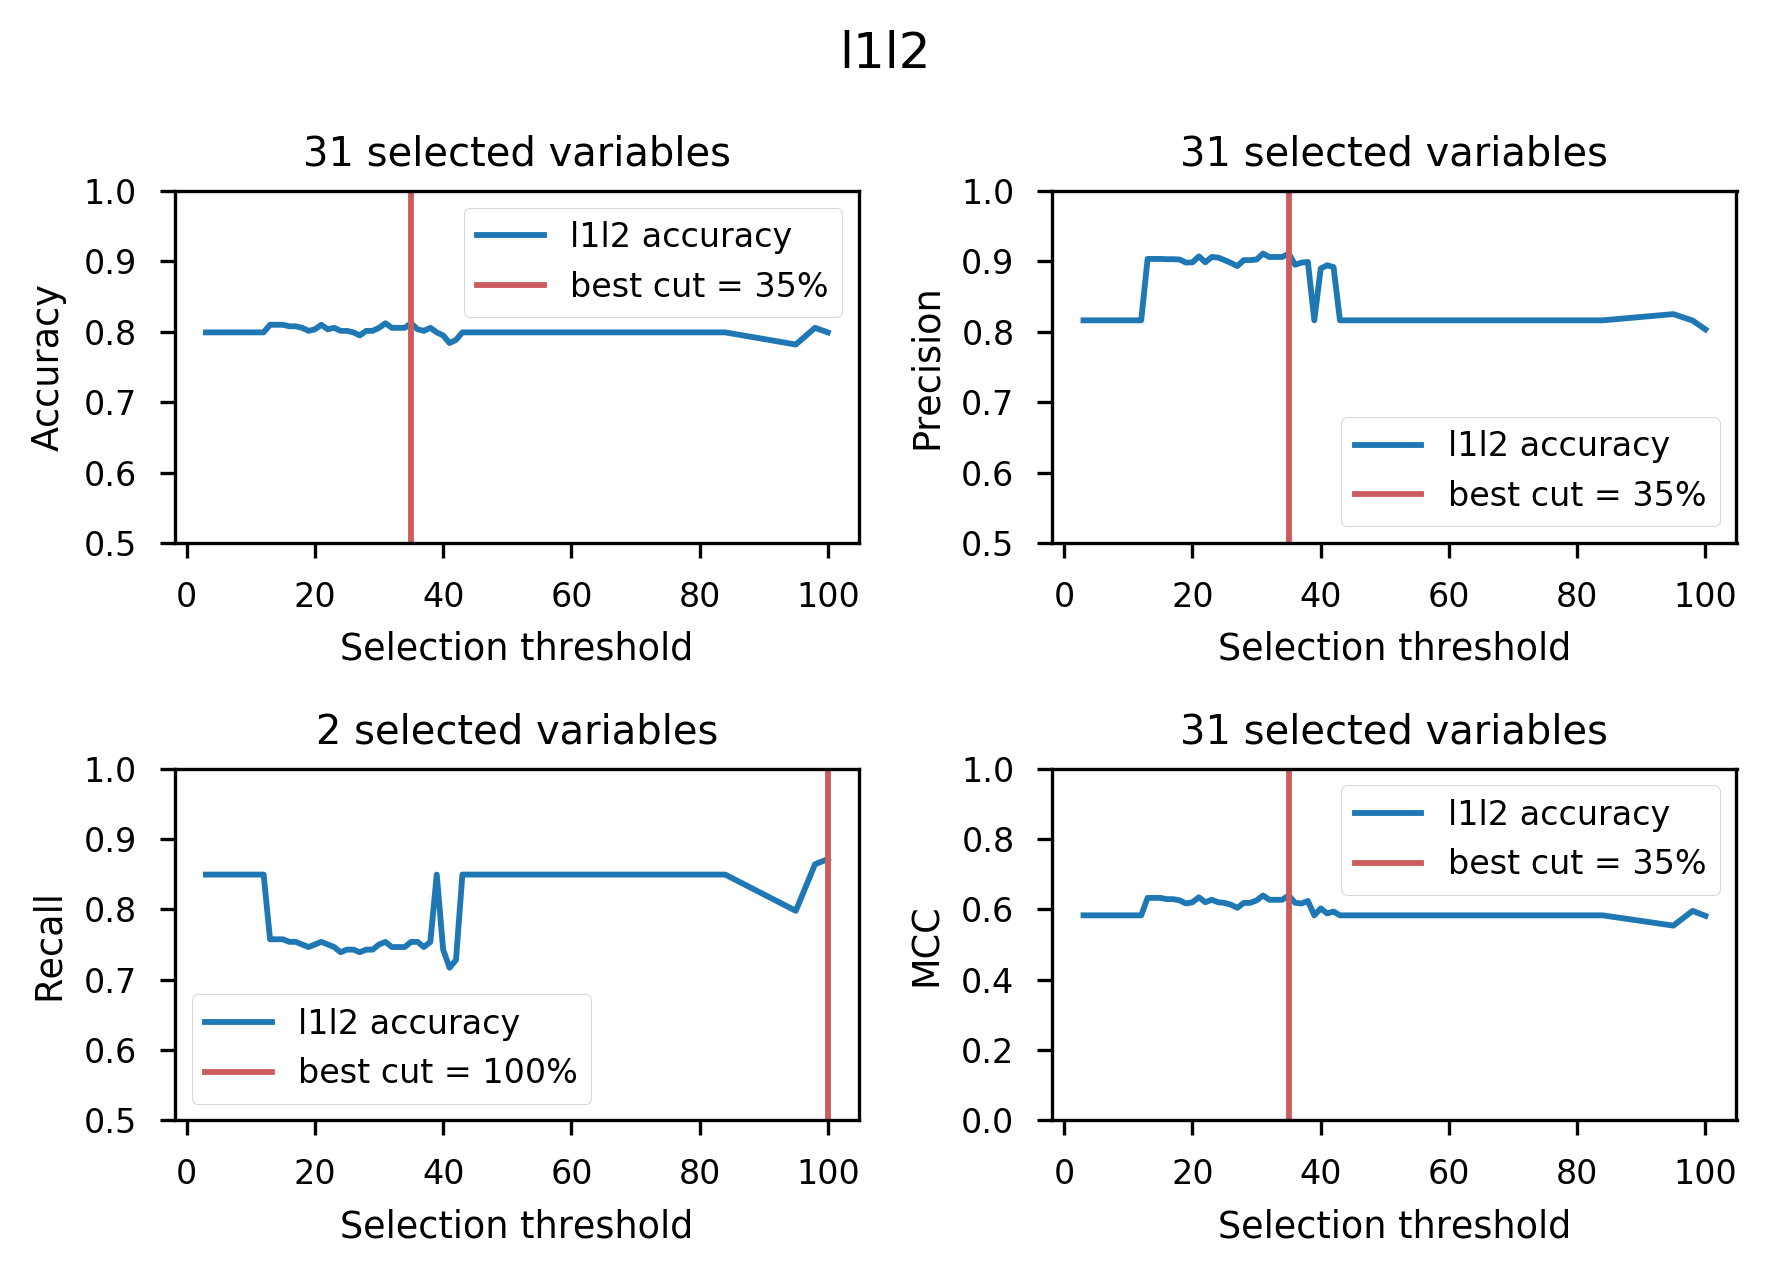

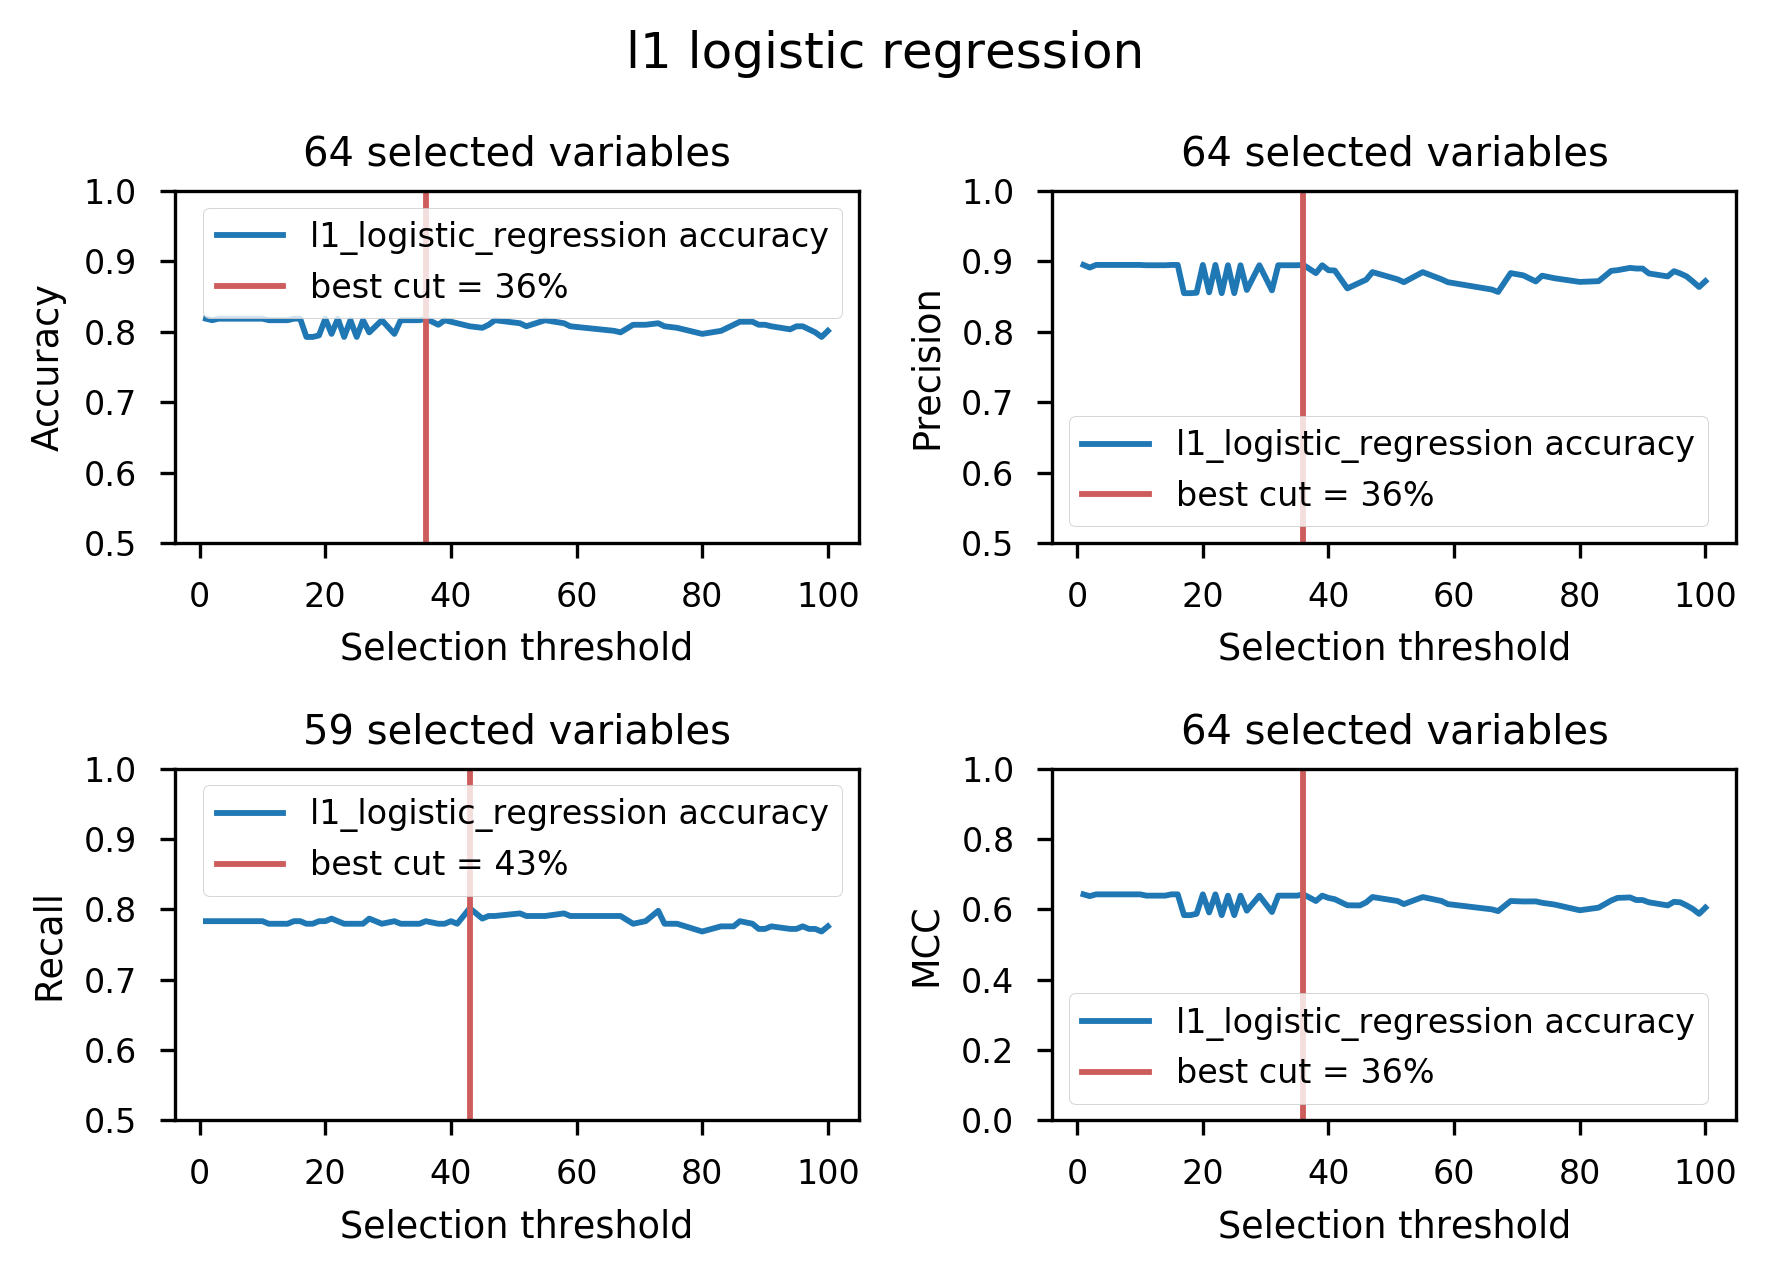

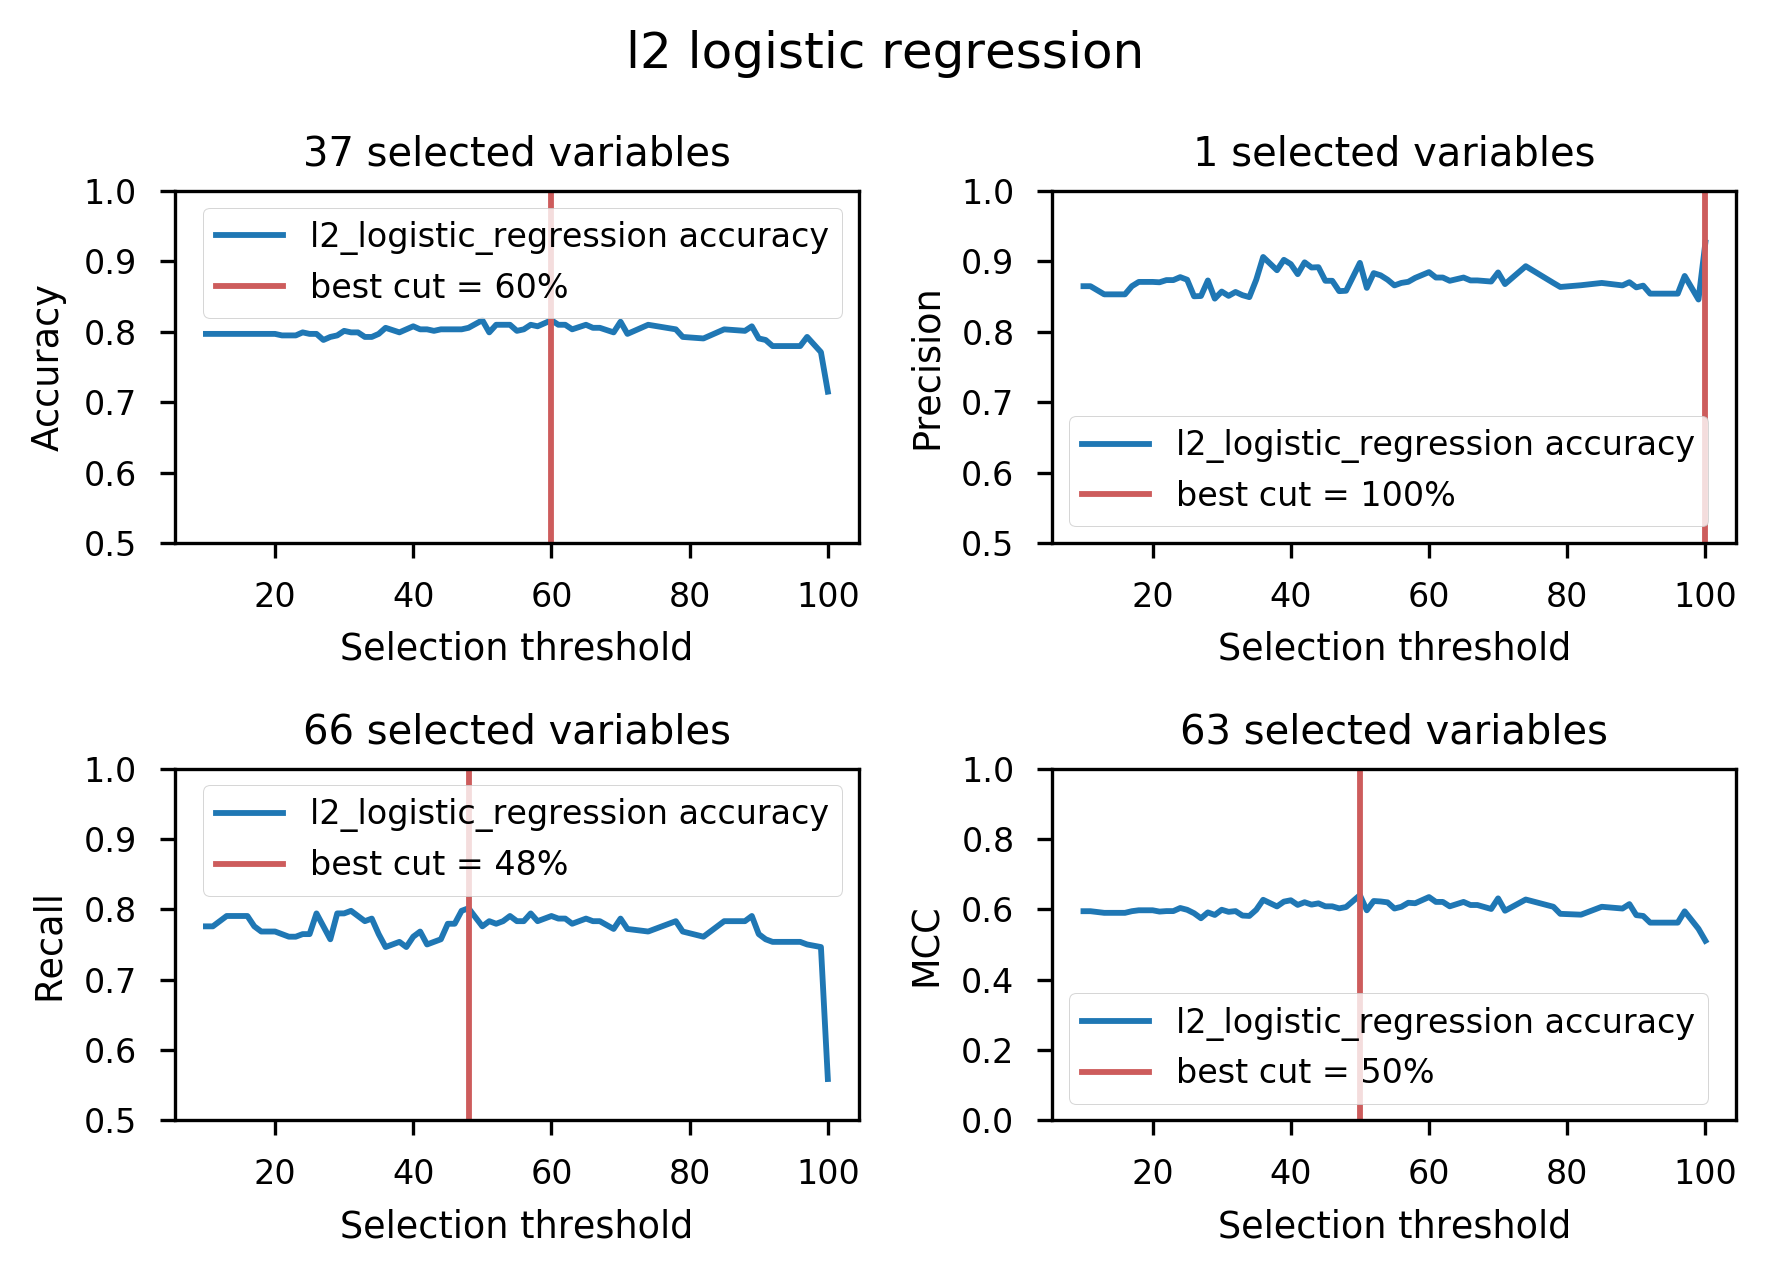

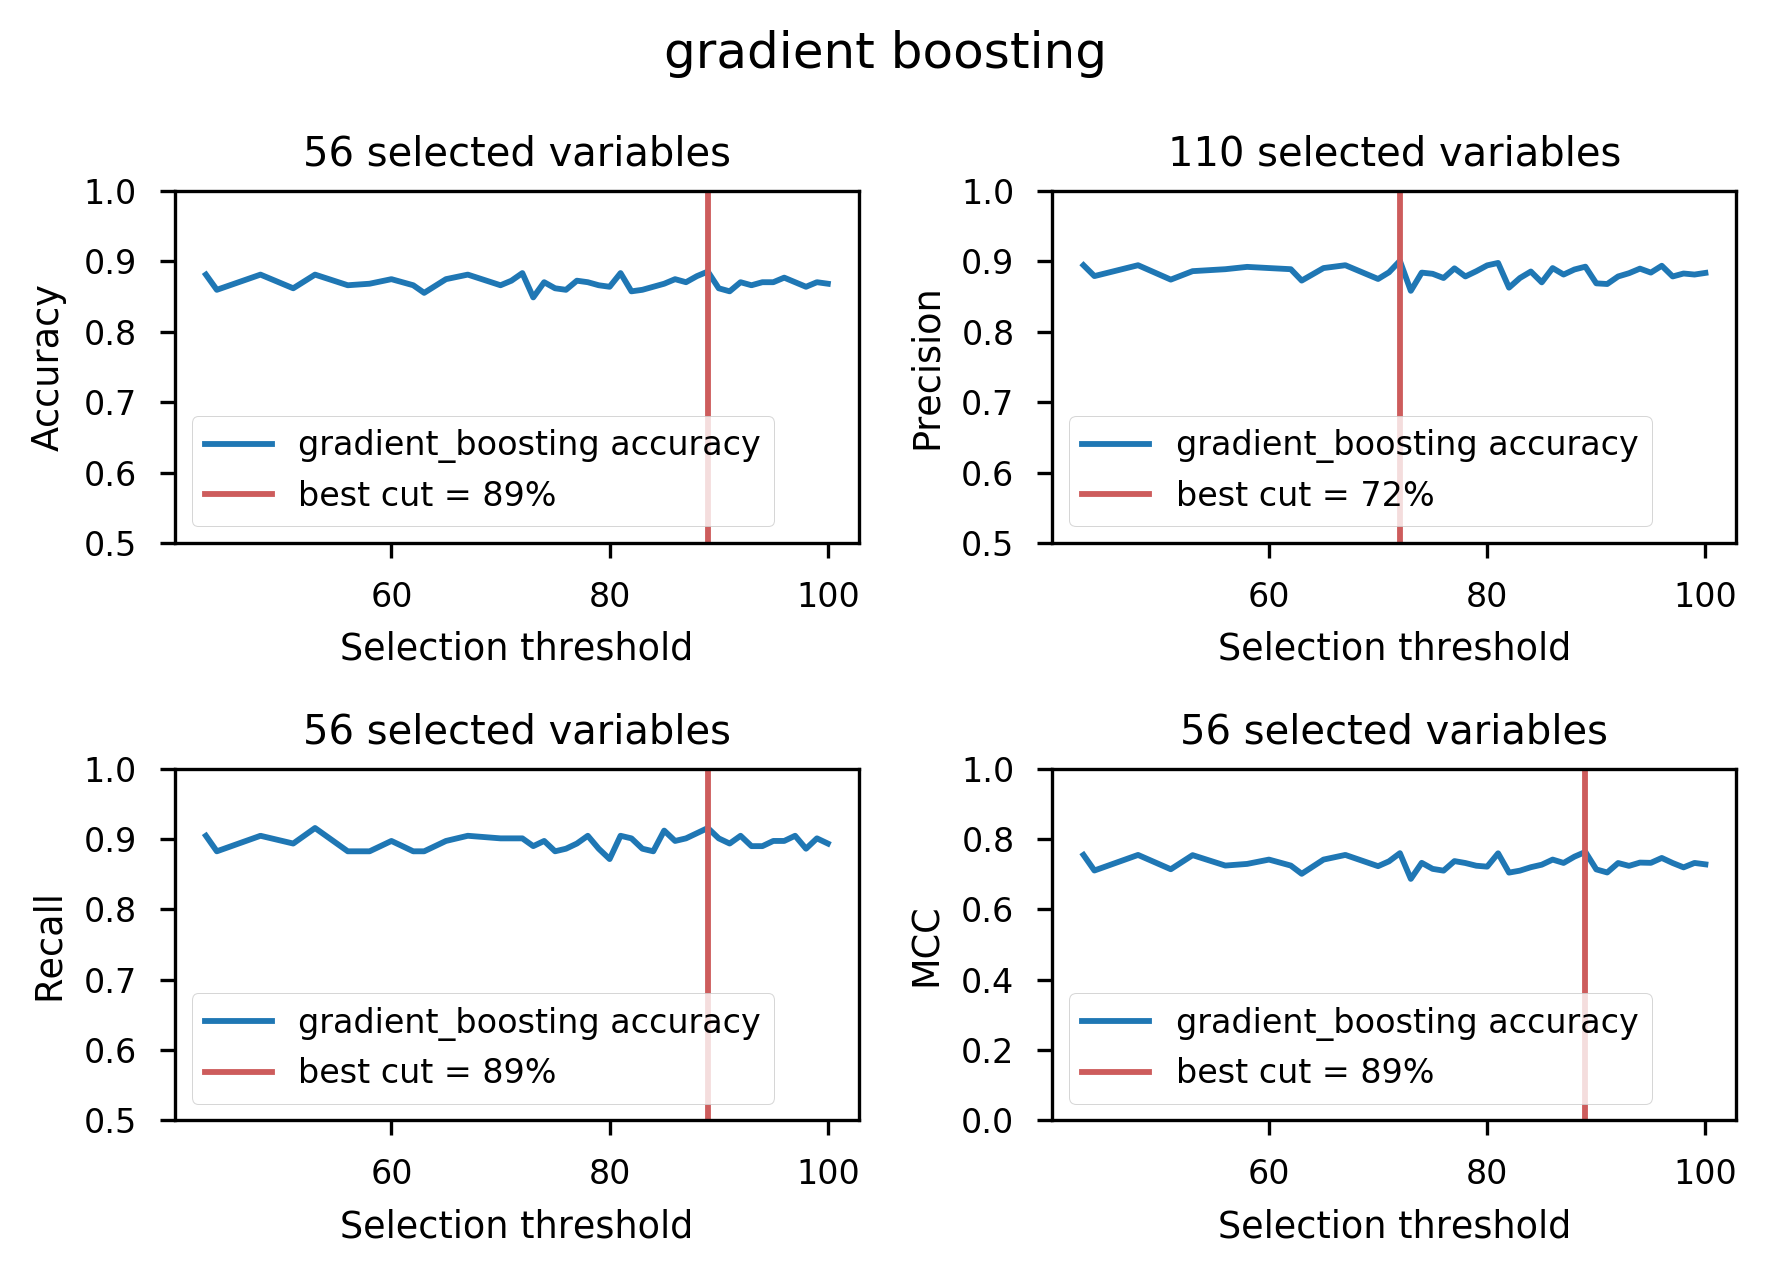

In [24]:
# Evaluate the scores trend
selected_dict = {}
for name in model_scores_trend.keys():
    
    mccs = []
    accs = []
    precs = []
    rclls = []
    for t in model_scores_trend[name].keys(): # for each time
        mccs.append(model_scores_trend[name][t]['MCC'])
        accs.append(model_scores_trend[name][t]['accuracy'])
        precs.append(model_scores_trend[name][t]['precision'])
        rclls.append(model_scores_trend[name][t]['recall'])
    sel_thresholds = np.array(model_scores_trend[name].keys())

    # Plot results
    plt.figure(dpi=300)
    plt.suptitle(name.replace('_',' '), y=1.05)
    
    # Accuracy
    best_cut = sel_thresholds[np.where(accs == max(accs))[0][-1]]
    best_cut_idx = np.where(rankings[name].values.ravel() >= best_cut)[0]
    selected_variables = rankings[name].iloc[best_cut_idx].index.tolist()
    
    plt.subplot(2,2,1)
    plt.plot(model_scores_trend[name].keys(), accs, '-', label=name+' accuracy')
    plt.axvline(best_cut, c='indianred', label='best cut = {}%'.format(best_cut))
    plt.xlabel('Selection threshold')
    plt.ylabel('Accuracy')
    plt.ylim([0.5, 1.0])
    plt.title('{} selected variables'.format(len(selected_variables)))
    plt.legend()
    
    # Precision
    best_cut = sel_thresholds[np.where(precs == max(precs))[0][-1]]
    best_cut_idx = np.where(rankings[name].values >= best_cut)[0]
    selected_variables = rankings[name].iloc[best_cut_idx].index.tolist()
    
    plt.subplot(2,2,2)
    plt.plot(model_scores_trend[name].keys(), precs, '-', label=name+' accuracy')
    plt.axvline(best_cut, c='indianred', label='best cut = {}%'.format(best_cut))
    plt.xlabel('Selection threshold')
    plt.ylabel('Precision')
    plt.ylim([0.5, 1.0])
    plt.title('{} selected variables'.format(len(selected_variables)))
    plt.legend()
    
    # Recall
    best_cut = sel_thresholds[np.where(rclls == max(rclls))[0][-1]]
    best_cut_idx = np.where(rankings[name].values >= best_cut)[0]
    selected_variables = rankings[name].iloc[best_cut_idx].index.tolist()
    
    plt.subplot(2,2,3)
    plt.plot(model_scores_trend[name].keys(), rclls, '-', label=name+' accuracy')
    plt.axvline(best_cut, c='indianred', label='best cut = {}%'.format(best_cut))
    plt.xlabel('Selection threshold')
    plt.ylabel('Recall')
    plt.ylim([0.5, 1.0])
    plt.title('{} selected variables'.format(len(selected_variables)))
    plt.legend()
    
    # MCC -- index chosen for the optimization --
    best_cut = sel_thresholds[np.where(mccs == max(mccs))[0][-1]]
    best_cut_idx = np.where(rankings[name].values >= best_cut)[0]
    selected_variables = rankings[name].iloc[best_cut_idx].index.tolist()
    
    selected_dict[name] = selected_variables
    plt.subplot(2,2,4)
    plt.plot(model_scores_trend[name].keys(), mccs, '-', label=name+' accuracy')
    plt.axvline(best_cut, c='indianred', label='best cut = {}%'.format(best_cut))
    plt.xlabel('Selection threshold')
    plt.ylabel('MCC')
    plt.ylim([0, 1.0])
    plt.title('{} selected variables'.format(len(selected_variables)))
    plt.legend()
    
    plt.tight_layout()
    plt.savefig(name+'_scores_trend.png', bbox_inches='tight')

# 4. Train only on relevant features

In [35]:
# Merge training and validation
x_train = pd.concat([data_tr, data_vld])
y_train = pd.concat([labels_tr, labels_vld])

In [36]:
# Test
data_test = pd.read_csv('../../scripts/aism/dataset_12-2017/data_test.csv', header=0, index_col=0)
labels_test = pd.read_csv('../../scripts/aism/dataset_12-2017/labels_test.csv', header=0, index_col=0)
yy = np.where(labels_test.values == 'SP', 1, 0)  # map RR - SP / 0 - 1
labels_test = pd.DataFrame(data=yy, index=labels_test.index, columns=labels_test.columns)

In [51]:
scores = {}
for name in models.keys():
    print('Evaluating {} ...'.format(name))
    mdl = models[name]
    
    # Use only selected variables
    _x_train = x_train[selected_dict[name]]    
    
    # Fit the model
    mdl.fit(_x_train, y_train)
    
    scores[name] = evaluate(mdl, data_test[selected_dict[name]], labels_test)
print('done.')

Evaluating linear_svc_l2 ...
Evaluating linear_svc_l1 ...
Evaluating random_forests ...
Evaluating l1l2 ...
Evaluating l1_logistic_regression ...
Evaluating l2_logistic_regression ...
Evaluating gradient_boosting ...
done.


In [52]:
from scipy.stats import hmean

scores_tab = pd.DataFrame(scores).transpose()
scores_tab['F1'] = [hmean([p, r]) for p,r in zip(scores_tab['precision'].values, scores_tab['recall'].values)]
scores_tab

,MCC,accuracy,precision,recall,F1
gradient_boosting,0.743573,0.874735,0.920074,0.868421,0.893502
l1_logistic_regression,0.610582,0.800425,0.897917,0.756140,0.820952
l1l2,0.626874,0.800425,0.928251,0.726316,0.814961
l2_logistic_regression,0.583857,0.789809,0.878049,0.757895,0.813559
linear_svc_l1,0.594092,0.792994,0.888199,0.752632,0.814815
linear_svc_l2,0.583656,0.786624,0.886792,0.742105,0.808023
random_forests,0.690158,0.850318,0.889292,0.859649,0.874219


In [48]:
# std

scores_tab = pd.DataFrame(scores).transpose()
scores_tab['F1'] = [hmean([p, r]) for p,r in zip(scores_tab['precision'].values, scores_tab['recall'].values)]
scores_tab

,MCC,accuracy,precision,recall,F1
gradient_boosting,0.698183,0.854565,0.890090,0.866667,0.878222
l1_logistic_regression,0.602053,0.798301,0.887755,0.763158,0.820755
l1l2,0.630173,0.802548,0.928571,0.729825,0.817289
l2_logistic_regression,0.587124,0.788747,0.887265,0.745614,0.810296
linear_svc_l1,0.595811,0.792994,0.891441,0.749123,0.814109
linear_svc_l2,0.588194,0.786624,0.895075,0.733333,0.806172
random_forests,0.697396,0.853503,0.894161,0.859649,0.876565
